# Data augmentation

Het verzamelen van voldoende data kan zeer tijdrovend en kostelijk zijn.
Daarom zou het handig zijn om op een automatische manier extra data aan te maken.
Dit is wat data augmentation doet en wordt vaak gebruikt wanneer er gewerkt wordt met visuele of auditieve data.
De code hieronder zal vooral een voorbeeld zijn van hoe je data augmentatie kan toepassen op beelden/images.
Hierbij gaan we voor het trainen op een random manier een variatie maken van de figuur.
Doordat er meerdere epochs gebruikt worden bij training zullen er op die manier meerdere varianten van elke figuur gebruikt worden bij training.

Data augmentation kan je meestal toepassen zonder problemen. Zeker de opties waarbij geen pixels verdwijnen geven normaal geen issues.
Let echter wel op als je roteert of cropt en hetgene dat je moet detecteren aan de rand van je scherm ligt, dat dat object kan verdwijnen.
Indien je genoeg epochs gebruikt zou dit echter geen groot probleem mogen zijn door compensatie in de andere epochs.

In de vorige notebook hadden we onderstaande model om een classificatie CNN te maken. 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Stap 1: Dataset Inladen en Voorbereiden
train_transform = transforms.Compose([ 
    transforms.ToTensor(),  # Zet de afbeelding om naar een tensor en normaliseer naar [0, 1]
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1)
])

test_transform = transforms.Compose([ 
    transforms.ToTensor(),  # Zet de afbeelding om naar een tensor en normaliseer naar [0, 1]

    # We willen bij testdata geen random transformaties doen (overhead die niet nodig is en je resultaten kan beinvloeden
])

# Laad de CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the CNN model using torch.nn.Sequential
model = nn.Sequential(
    nn.Conv2d(3, 6, 5),       # Convolutional layer: input channels=3, output channels=6, kernel size=5
    nn.ReLU(),                # ReLU activation
    nn.MaxPool2d(2, 2),       # Max pooling layer: kernel size=2, stride=2
    nn.Conv2d(6, 16, 5),      # Convolutional layer: input channels=6, output channels=16, kernel size=5
    nn.ReLU(),                # ReLU activation
    nn.MaxPool2d(2, 2),       # Max pooling layer: kernel size=2, stride=2
    nn.Flatten(),             # Flatten the output for the fully connected layers
    nn.Linear(16 * 5 * 5, 120), # Fully connected layer: input features=16*5*5, output features=120
    nn.ReLU(),                # ReLU activation
    nn.Linear(120, 84),       # Fully connected layer: input features=120, output features=84
    nn.ReLU(),                # ReLU activation
    nn.Linear(84, 10)         # Output layer: input features=84, output features=10 (number of classes)
)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(2):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# Evaluate the model
dataiter = iter(testloader)
images, labels = next(dataiter)

# Make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Print the image, true labels, and predicted labels
def imshow(img):
    img = img.permute(1, 2, 0).numpy()  # Convert back to HxWxC
    plt.imshow(img)
    plt.show()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(4)))
print('Predicted:  ', ' '.join(f'{trainset.classes[predicted[j]]:5s}' for j in range(4)))

Om op de cifar10 dataset data augmentation uit te voeren moeten we enkel de transform stappenplan aanpassen om op een random manier bewerkingen uit te voeren op de figuren.
We kunnen bijvoorbeeld de transform aanpassen als volgt:

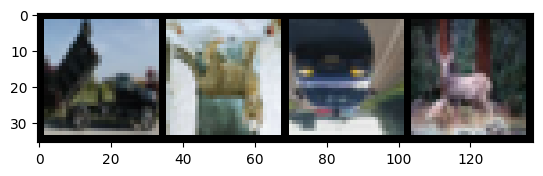

In [5]:
# Evaluate the model
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the image, true labels, and predicted labels
def imshow(img):
    img = img.permute(1, 2, 0).numpy()  # Convert back to HxWxC
    plt.imshow(img)
    plt.show()

# Print images
imshow(torchvision.utils.make_grid(images))

## Keras

De analoge oplossing om dit te doen met keras is door het model in onderstaande voorbeeld

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Rescaling
import keras
from keras import Sequential
from keras.layers import Conv2D, Rescaling, MaxPooling2D, Flatten, Dense

# Laad en bereid de CIFAR-10 dataset voor
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Min-Max scaling naar [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Definieer het CNN-model met tf.keras.Sequential
model = Sequential([
    Rescaling(1.0/255.0),
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile het model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train het model
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_split=0.1, verbose=2)

# Evalueer het model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

# Maak voorspellingen
predictions = model.predict(x_test)

aan te passen op twee mogelijke manieren. 
Ten eerste kunnen de random transformaties uitgevoerd worden door een ImageDataGenerator zoals in onderstaande voorbeeld

of door extra lagen toe te voegen aan het model als volgt